In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.layers import Dense
import json 
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [ ]:
file_path = "drive/My Drive/Tensorflow/Conversation.csv"

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,question,answer
0,0,"hi, how are you doing?",i'm fine. how about yourself?
1,1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,3,no problem. so how have you been?,i've been great. what about you?
4,4,i've been great. what about you?,i've been good. i'm in school right now.


In [ ]:
def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    text = '<sos> ' + text + ' <eos>'

    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

In [ ]:
df["question"][0]

'<sos> hi how are you doing <eos>'

In [ ]:
question  = df.question.values.tolist()
answer =  df.answer.values.tolist()

In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [ ]:
input_tensor , inp_lang  =  tokenize(question)
target_tensor , tar_lang  =  tokenize(answer)

In [ ]:
input_tensor

array([[  1, 966,  37, ...,   0,   0,   0],
       [  1,   3,  26, ...,   0,   0,   0],
       [  1,   3,  26, ...,   0,   0,   0],
       ...,
       [  1,  30,  56, ...,   0,   0,   0],
       [  1,   4,  13, ...,   0,   0,   0],
       [  1,  31,   3, ...,   0,   0,   0]], dtype=int32)

In [ ]:
detokenized_sentences = inp_lang.sequences_to_texts([input_tensor[0]])
print("Detokenized sentences: ",detokenized_sentences)

Detokenized sentences:  ['<sos> hi how are you doing <eos>']


In [ ]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
max_length_targ

22

In [ ]:
MAX_TOKENS = max_length_targ

In [ ]:
max_length_inp

22

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [ ]:
input_tensor_train = tf.ragged.constant(input_tensor_train, dtype=tf.int32).to_tensor()
input_tensor_val = tf.ragged.constant(input_tensor_val, dtype=tf.int32).to_tensor()
target_tensor_train = tf.ragged.constant(target_tensor_train, dtype=tf.int32).to_tensor()
target_tensor_val = tf.ragged.constant(target_tensor_val, dtype=tf.int32).to_tensor()

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(tar_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
validation = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
validation = validation.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def prepare_batch(inp, tar):

    tar_inputs = tar[:, :-1]  # Drop  <eos>
    tar_labels = tar[:, 1:] # drop <sos>

    return(inp, tar_inputs), tar_labels

In [ ]:
train_dataset = dataset.map(prepare_batch)
val_dataset = validation.map(prepare_batch)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 22]))

In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

## Modeling

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [ ]:
embed_inp = PositionalEmbedding(vocab_size=vocab_inp_size, d_model=256)
embed_tar = PositionalEmbedding(vocab_size=vocab_tar_size, d_model=256)

inp_emb = embed_inp(example_input_batch)
tar_emb = embed_tar(example_target_batch)

In [ ]:
inp_emb._keras_mask

<tf.Tensor: shape=(64, 22), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=256)

print(inp_emb.shape)
print(tar_emb.shape)
print(sample_ca(inp_emb, tar_emb).shape)

(64, 22, 256)
(64, 22, 256)
(64, 22, 256)


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(inp_emb.shape)
print(sample_gsa(inp_emb).shape)

(64, 22, 256)
(64, 22, 256)


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(tar_emb.shape)
print(sample_csa(tar_emb).shape)

(64, 22, 256)
(64, 22, 256)


In [ ]:
out1 = sample_csa(embed_tar(example_target_batch[:, :3])) 
out2 = sample_csa(embed_tar(example_target_batch))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


In [ ]:
sample_ffn = FeedForward(256, 1024)

print(tar_emb.shape)
print(sample_ffn(tar_emb).shape)

(64, 22, 256)
(64, 22, 256)


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=256, num_heads=8, dff=1024)

print(inp_emb.shape)
print(sample_encoder_layer(inp_emb).shape)

(64, 22, 256)
(64, 22, 256)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=256,
                         num_heads=8,
                         dff=1024,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(example_input_batch, training=False)

# Print the shape.
print(example_input_batch.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 22)
(64, 22, 256)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=256, num_heads=8, dff=1024)

sample_decoder_layer_output = sample_decoder_layer(
    x=tar_emb, context=inp_emb)

print(tar_emb.shape)
print(inp_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 22, 256)
(64, 22, 256)
(64, 22, 256)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=256,
                         num_heads=8,
                         dff=1024,
                         vocab_size=8000)

output = sample_decoder(
    x=example_target_batch,
    context=inp_emb)

# Print the shapes.
print(example_target_batch.shape)
print(inp_emb.shape)
print(output.shape)

(64, 22)
(64, 22, 256)
(64, 22, 256)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 22, 22])

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
num_layers = 4
d_model = 128
dff = 256
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_inp_size,
    target_vocab_size=vocab_tar_size,
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((example_input_batch, example_target_batch))

print(example_target_batch.shape)
print(example_input_batch.shape)
print(output.shape)

(64, 22)
(64, 22)
(64, 22, 2439)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 22, 22)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2679680   
                                                                 
 decoder_1 (Decoder)         multiple                  4798848   
                                                                 
 dense_38 (Dense)            multiple                  314631    
                                                                 
Total params: 7,793,159
Trainable params: 7,793,159
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

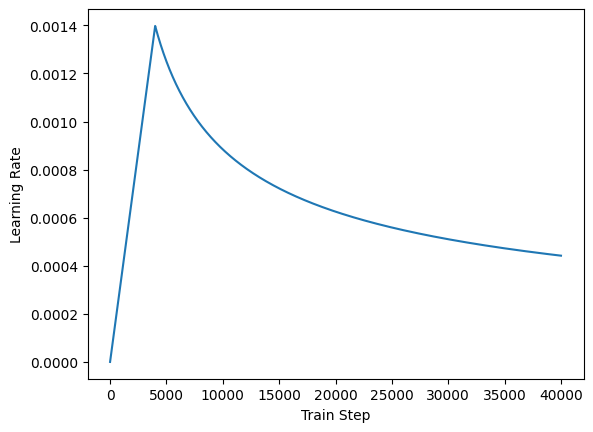

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_dataset,
                epochs=100,
                validation_data=val_dataset)

Epoch 1/100
46/46 [==============================] - 52s 342ms/step - loss: 7.7490 - masked_accuracy: 0.0231 - val_loss: 7.4934 - val_masked_accuracy: 0.1289
Epoch 2/100
46/46 [==============================] - 8s 175ms/step - loss: 7.3371 - masked_accuracy: 0.1268 - val_loss: 7.1551 - val_masked_accuracy: 0.1289
Epoch 3/100
46/46 [==============================] - 5s 111ms/step - loss: 7.0712 - masked_accuracy: 0.1266 - val_loss: 6.9039 - val_masked_accuracy: 0.1289
Epoch 4/100
46/46 [==============================] - 5s 103ms/step - loss: 6.7856 - masked_accuracy: 0.1463 - val_loss: 6.5998 - val_masked_accuracy: 0.1550
Epoch 5/100
46/46 [==============================] - 4s 74ms/step - loss: 6.4553 - masked_accuracy: 0.1537 - val_loss: 6.2607 - val_masked_accuracy: 0.1577
Epoch 6/100
46/46 [==============================] - 4s 81ms/step - loss: 6.0994 - masked_accuracy: 0.1544 - val_loss: 5.9147 - val_masked_accuracy: 0.1578
Epoch 7/100
46/46 [==============================] - 3s 64m

In [ ]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
MAX_TOKENS

22

In [ ]:
class Chatbot(tf.Module):
  def __init__(self, input_tokenizer, output_tokenizer, transformer):
    self.input_tokenizer = input_tokenizer
    self.output_tokenizer = output_tokenizer
    self.transformer = transformer

  def __call__(self, sentence):
    # sentence = clean_text(sentence)
    max_length = 22

    
    encode_input = sentence
    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start = self.input_tokenizer.texts_to_sequences(['<sos>'])
    start = tf.keras.preprocessing.sequence.pad_sequences(start,
                                                         padding='post')
    start = tf.ragged.constant(start).to_tensor()[0]

    end = self.input_tokenizer.texts_to_sequences(['<eos>'])
    end = tf.keras.preprocessing.sequence.pad_sequences(end,
                                                         padding='post')
    end = tf.ragged.constant(end).to_tensor()[0]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encode_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output = output[0].numpy()
    # # The output shape is `(1, tokens)`.
    # text = self.output_tokenizer.sequences_to_texts([output])

    # # `tf.function` prevents us from using the attention_weights that were
    # # calculated on the last iteration of the loop.
    # # So, recalculate them outside the loop.
    # # self.transformer([encode_input, output[:,:-1]], training=False)
    # # attention_weights = self.transformer.decoder.last_attn_scores

    # return text
    return output


In [ ]:
chatbot = Chatbot(inp_lang,tar_lang, transformer)

In [ ]:
class ExportChatbot(tf.Module):
  def __init__(self, chatbot):
    self.chatbot = chatbot

  @tf.function(input_signature=[tf.TensorSpec(shape=[None,None], dtype=tf.int32)])
  def __call__(self, sentence):
    reply = self.chatbot(sentence)

    return reply

In [ ]:
chatbot = ExportChatbot(chatbot)

In [ ]:
input = 'Are these two different'
encode_input = inp_lang.texts_to_sequences([input])
encode_input = tf.keras.preprocessing.sequence.pad_sequences(encode_input,
                                                         padding='post')
encode_input = tf.ragged.constant(encode_input, dtype=tf.int32).to_tensor()
output = chatbot(
encode_input)

output = output[0].numpy()
text = tar_lang.sequences_to_texts([output])
text

['<sos> so do i have to throw it the money <eos>']

In [ ]:
# input = 'why are you'

# output = chatbot(
# input)
# output

In [ ]:
model_path = "drive/My Drive/Tensorflow/mymodel"

tf.saved_model.save(chatbot, model_path)


In [ ]:
loaded_model = tf.saved_model.load(model_path)

In [ ]:
# input = 'are you ok'

# output = loaded_model(
# input)
# output

In [ ]:
input = 'Are these two different'
encode_input = inp_lang.texts_to_sequences([input])
encode_input = tf.keras.preprocessing.sequence.pad_sequences(encode_input,
                                                         padding='post')
encode_input = tf.ragged.constant(encode_input, dtype=tf.int32).to_tensor()
output = loaded_model(
encode_input)

output = output[0].numpy()
text = tar_lang.sequences_to_texts([output])
text

['<sos> so do i have to throw it the money <eos>']

In [ ]:
file_path = "drive/My Drive/Tensorflow/"

In [ ]:
inp_lang_json = inp_lang.to_json()
with open(file_path + 'inp_lang.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(inp_lang_json, ensure_ascii=False))

In [ ]:
tar_lang_json = tar_lang.to_json()
with open(file_path + 'tar_lang.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tar_lang_json, ensure_ascii=False))

In [ ]:
with open(file_path + 'inp_lang.json') as f:
    json_data = json.load(f)
    inp_tokenizer = tokenizer_from_json(json_data)

In [ ]:
with open(file_path + 'tar_lang.json') as f:
    json_data = json.load(f)
    tar_tokenizer = tokenizer_from_json(json_data)

In [ ]:
input = 'Are these two different'
encode_input = inp_tokenizer.texts_to_sequences([input])
encode_input = tf.keras.preprocessing.sequence.pad_sequences(encode_input,
                                                         padding='post')
encode_input = tf.ragged.constant(encode_input, dtype=tf.int32).to_tensor()
output = loaded_model(
encode_input)

output = output[0].numpy()
text = tar_tokenizer.sequences_to_texts([output])
text

['<sos> so do i have to throw it the money <eos>']

In [ ]:
!ls

drive  inp_lang.json  sample_data  tar_lang.json


In [ ]:
!pwd

/content
